# Analysis

## Set-up data for the experiments

In [2]:
import os
import pandas as pd


datamatrixDf = pd.read_csv(os.environ['MIMIC_EHR_PIPELINE_BASE'] + '''/data/sepsis_icd_cohort/final/data_matrix.csv''')
datamatrixDf

,person_id,visit_occurrence_id,measurement_date,visit_start_datetime_adm,death_datetime_adm,death_0_7_adm,death_0_14_adm,death_0_21_adm,death_0_30_adm,death_0_60_adm,...,labs_Prothrombin time (PT)_last,labs_INR in Platelet poor plasma by Coagulation assay_last,labs_aPTT in Blood by Coagulation assay_last,labs_Specific gravity of Urine by Test strip_last,labs_pH of Urine by Test strip_last,labs_Bilirubin.total in Serum or Plasma_last,labs_Aspartate aminotransferase in Serum or Plasma_last,labs_Alanine aminotransferase in Serum or Plasma_last,labs_Alkaline phosphatase in Serum or Plasma_last,labs_Albumin in Serum or Plasma_last
0,-1197427589,-2146275445,2123-04-12,2123-04-11 12:39:00,2128-05-15 00:00:00,0,0,0,0,0,...,25.000000,2.400000,55.3,1.023815,5.885000,0.800000,85.000000,52.0000,159.000000,2.605000
1,-1197427589,-2146275445,2123-04-13,2123-04-11 12:39:00,2128-05-15 00:00:00,0,0,0,0,0,...,22.700000,2.150000,60.9,1.019660,6.100000,0.500000,58.000000,61.0000,219.000000,2.542500
2,-1197427589,-2146275445,2123-04-14,2123-04-11 12:39:00,2128-05-15 00:00:00,0,0,0,0,0,...,20.900000,1.900000,62.3,1.014580,5.950000,0.500000,31.000000,38.0000,238.000000,2.389000
3,-1197427589,-2146275445,2123-04-15,2123-04-11 12:39:00,2128-05-15 00:00:00,0,0,0,0,0,...,22.800000,2.200000,62.8,1.015280,5.622500,0.300000,28.000000,30.0000,254.000000,2.303333
4,-1197427589,-2146275445,2123-04-16,2123-04-11 12:39:00,2128-05-15 00:00:00,0,0,0,0,0,...,25.000000,2.400000,62.8,1.010677,5.464167,1.777500,64.603333,62.1225,290.913333,2.324500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10484,-846098588,2138042415,2149-12-18,2149-12-01 06:39:00,2152-01-12 19:22:00,0,0,0,0,0,...,13.200000,1.100000,25.5,1.013060,6.620000,1.593500,42.020000,49.2150,370.938333,2.525000
10485,-846098588,2138042415,2149-12-19,2149-12-01 06:39:00,2152-01-12 19:22:00,0,0,0,0,0,...,13.100000,1.100000,30.1,1.016555,6.667500,0.600000,43.000000,37.0000,392.000000,2.724000
10486,-846098588,2138042415,2149-12-20,2149-12-01 06:39:00,2152-01-12 19:22:00,0,0,0,0,0,...,12.900000,1.100000,35.6,1.013160,6.742500,0.600000,42.000000,38.0000,369.000000,2.900000
10487,1039874845,2143115001,2136-09-29,2136-09-28 18:22:00,2136-10-03 21:20:00,1,1,1,1,1,...,14.100000,1.300000,23.6,1.015082,6.262500,4.999500,91.138333,86.7800,221.340000,2.956500


### Check class counts

In [3]:
datamatrixDf.death_0_7_adm.value_counts()

death_0_7_adm
0    9898
1     591
Name: count, dtype: int64

### Separate positive and negative classes

In [4]:
dataMatrixPositiveDf = datamatrixDf[datamatrixDf.death_0_7_adm == 1]
dataMatrixNegativeDf = datamatrixDf[datamatrixDf.death_0_7_adm == 0]

In [5]:
dataMatrixPositiveDf.shape, dataMatrixNegativeDf.shape

((591, 278), (9898, 278))

In [6]:
dataMatrixPositiveDf.visit_occurrence_id.isin(dataMatrixNegativeDf.visit_occurrence_id).sum()

0

In [7]:
len(dataMatrixPositiveDf.visit_occurrence_id.unique()), len(dataMatrixNegativeDf.visit_occurrence_id.unique())

(315, 1475)

In [14]:
totalPositiveSamples = 591
dataSizeList = []
for proportion in [50, 55, 60, 65, 70, 75, 80, 85, 90]:
    positiveSize = totalPositiveSamples
    negativeSize = int(totalPositiveSamples * proportion / (100 - proportion))
    label = str(proportion) + '_' + str(100 - proportion)
    dataSizeList.append([negativeSize, positiveSize, label])
totalNegativeSamples = 9898
for proportion in [5]:
    positiveSize = int(totalNegativeSamples * proportion / (100 - proportion))
    negativeSize = totalNegativeSamples
    label = str(100 - proportion) + '_' + str(proportion)
    dataSizeList.append([negativeSize, positiveSize, label])
dataSizeList


[[591, 591, '50_50'],
 [722, 591, '55_45'],
 [886, 591, '60_40'],
 [1097, 591, '65_35'],
 [1379, 591, '70_30'],
 [1773, 591, '75_25'],
 [2364, 591, '80_20'],
 [3349, 591, '85_15'],
 [5319, 591, '90_10'],
 [9898, 520, '95_5']]

In [15]:
for [negativeSize, positiveSize, label] in dataSizeList:
    sampledDataMatrix = pd.concat([dataMatrixPositiveDf.sample(n=positiveSize), dataMatrixNegativeDf.sample(n=negativeSize)])
    sampledDataMatrix.to_csv(os.environ['MIMIC_EHR_PIPELINE_BASE'] + '/data/sepsis_icd_cohort/experiments/04_class_ratio_analysis/datamatrix/data_matrix_ratio_' + label + '.csv', index=False)


## Run the analysis

In [4]:
import os


for [negativeSize, positiveSize, label] in dataSizeList:
    print('Ratio: ' + label)
    os.system(
        'cd ' + os.environ['EHR_ML_BASE'] + ';'
        +
        '''.venv/bin/python -m ehrml.predict_mortality.Evaluate ''' + os.environ['MIMIC_EHR_PIPELINE_BASE'] + '''/data/sepsis_icd_cohort/experiments/04_class_ratio_analysis/datamatrix/data_matrix_ratio_''' + label + '''.csv -tc "death_0_7_adm" -ic "person_id" "visit_occurrence_id" -mdc "measurement_date" -adc "visit_start_datetime_adm" -wb ''' + str(0) + ''' -wa ''' + str(3) + ''' -sp ''' + os.environ['MIMIC_EHR_PIPELINE_BASE'] + '''/data/sepsis_icd_cohort/experiments/04_class_ratio_analysis/results/wb_0_wa_3_ratio_''' + label + '''.json;'''
        )


windowBefore: 0windowAfter: 1
2023-11-29 14:51:24,029 - EHR-ML - INFO - Parsing command line arguments
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.data_file: /home/yram0006/phd/chapter_2/workspace/MIMIC-EHR-Pipeline/data/sepsis_icd_cohort/final/data_matrix.csv
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.target_column: death_0_7_adm
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.id_columns: ['person_id', 'visit_occurrence_id']
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.measurement_date_column: measurement_date
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.anchor_date_column: visit_start_datetime_adm
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.window_before: 0
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.window_after: 1
2023-11-29 14:51:24,030 - EHR-ML - INFO - args.save_path: /home/yram0006/phd/chapter_2/workspace/MIMIC-EHR-Pipeline/data/sepsis_icd_cohort/experiments/01_time_window_analysis/ts_0_te_7_wb_0_wa_1
2023-11-29 14:51:24,589 - EHR-ML - INFO - Split data to test 

## Read the results

### Define data directory

In [34]:
import os

dataDirName = os.environ['MIMIC_EHR_PIPELINE_BASE'] + '''/data/sepsis_icd_cohort/experiments/04_class_ratio_analysis/results'''

### Load results in a DataFrame

In [38]:
import json
from pathlib import Path
import pandas as pd


data = []

for [negativeSize, positiveSize, label] in dataSizeList:
    scoresFile = Path(dataDirName, '''wb_0_wa_3_ratio_''' + label + '''.json''')
    if os.path.exists(scoresFile):
        with open(Path(scoresFile), 'rb') as f:
            results = json.load(f)
            aurocs = results['test_roc_auc']
            accuracies = results['test_accuracy']
            balanced_accuracies = results['test_balanced_accuracy']
            average_precisions = results['test_average_precision']
            f1_scores = results['test_f1']
            mccf1_scores = results['test_mccf1_score']
            data.append(['AUROC', int(label.split('_')[0]), sum(aurocs)/len(aurocs)])
            data.append(['Accuracy', int(label.split('_')[0]), sum(accuracies)/len(accuracies)])
            data.append(['Balanced Accuracy', int(label.split('_')[0]), sum(balanced_accuracies)/len(balanced_accuracies)])
            data.append(['Average Precision', int(label.split('_')[0]), sum(average_precisions)/len(average_precisions)])
            data.append(['F1 Scores', int(label.split('_')[0]), sum(f1_scores)/len(f1_scores)])
            data.append(['MCCF1 Scores', int(label.split('_')[0]), sum(mccf1_scores)/len(mccf1_scores)])
linePlotDf = pd.DataFrame(data, columns=['Metric', 'Ratio', 'Score'])

In [39]:
linePlotDf

,Metric,Ratio,Score
0,AUROC,50,0.686091
1,Accuracy,50,0.715766
2,Balanced Accuracy,50,0.572593
3,Average Precision,50,0.867090
4,F1 Scores,50,0.819427
5,MCCF1 Scores,50,0.678526
6,AUROC,55,0.673126
7,Accuracy,55,0.681081
8,Balanced Accuracy,55,0.575053
9,Average Precision,55,0.848797


## Plot

<Figure size 1200x600 with 0 Axes>

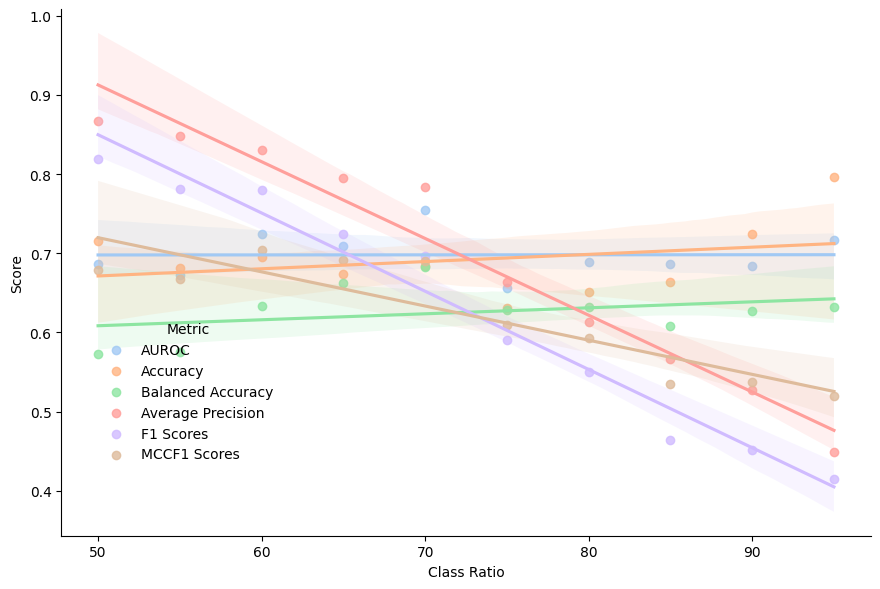

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12,6))
ax = sns.lmplot(
    data=linePlotDf,
    x='Ratio',
    y='Score',
    hue='Metric',
    palette=sns.color_palette("pastel"),
    height=6,
    aspect=1.5,
    # lowess=True,
    # scatter_kws={"s": 0},
    )
ax.set(xlabel='Class Ratio')
ax.set(ylabel='Score')
sns.move_legend(ax, "lower left", bbox_to_anchor=(.1, .2))
plt.show()
